<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC4</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Series temporales y combinación de modelos de clasificación

Está práctica está dividida en dos partes:

 - En el primer ejercicio veremos cómo descomponer y componer series temporales para realizar predicciones a futuro. 
 - En el segundo ejercicio estudiaremos diferentes técnicas mediante las que podremos combinar el resultado de múltiples clasificadores.

Para esta PEC se deben usar **únicamente las librerías que se importan a continuación**. Si se desea usar otra librería hay que consultarlo con el tutor/tutora del aula.

**Importante: cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega debe hacerse en formato notebook y en formato HTML donde se vea el código, los resultados y los comentarios de cada ejercicio. Para exportar el notebook a HTML puede hacerse desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong> Leroy Deniz Pedreira
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [36]:
# Custom imports
from sklearn.metrics import precision_score

# 1. Series temporales (6 puntos)

En este primer ejercicio trabajaremos las series temporales. Para ello, usaremos el dataset *AirPassangers* que contiene información del número de vuelos que se realizaron a lo largo de muchos años.

Empezaremos leyendo los datos y observando gráficamente su distribución. Como se puede apreciar es un claro caso de serie temporal, con heterocedasticidad, tendencia, periodo y ruido. A lo largo de este ejercicio trataremos cada uno de estos puntos.

In [2]:
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', header=0)
data.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

<AxesSubplot:xlabel='Month'>

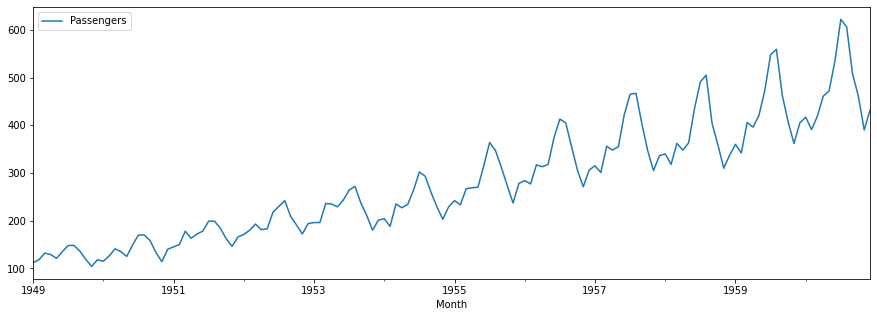

In [3]:
data.plot(figsize=(15, 5))

Antes de empezar a tratar las diferentes componenetes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.

In [4]:
TEST_SIZE = 24
train, test = data.iloc[:-TEST_SIZE].to_numpy(), data.iloc[-TEST_SIZE:].to_numpy()
x_train, x_test = np.arange(train.shape[0]), np.arange(train.shape[0], data.shape[0])
train.shape, x_train.shape, test.shape, x_test.shape

((120, 1), (120,), (24, 1), (24,))

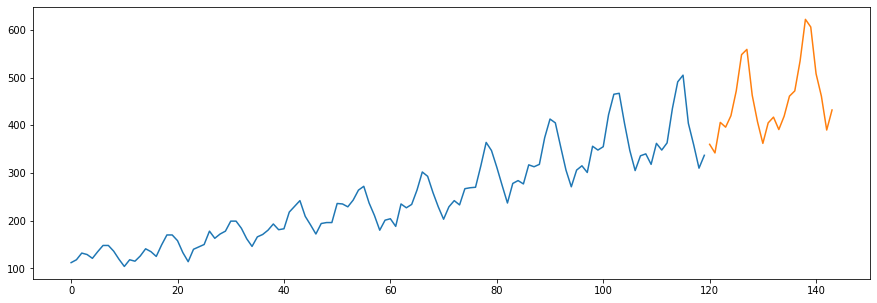

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

## 1.1 Componentes de la serie temporal

### 1.1.a. Heterocedasticidad

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad). En nuestro caso, observamos que tenemos heterocedasticidad, ya que la amplitud de onda varía con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> transforma los datos para eliminar la heterocedasticidad. Para ello debéis transformar los datos aplicando la función que consideréis que elimina mejor la heterocedasticidad en el dataset (exponencial, logarítmica, ...). Estas funciones ya están implementadas en numpy. Graficar los datos originales junto con los datos transformados.
</div>

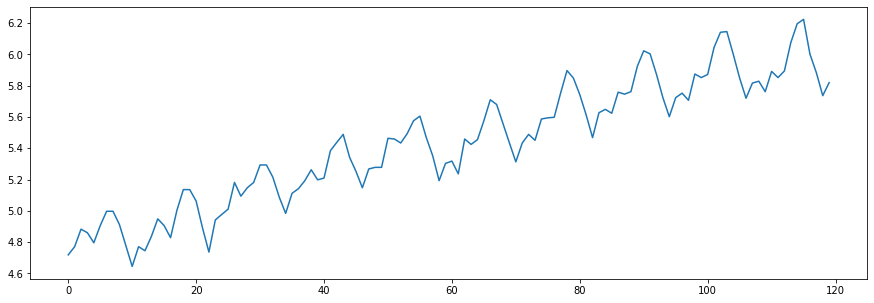

In [6]:
train_log = np.log(train)
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_log)

### 1.1.b. Tendencia

La tendencia es el comportamento que tienen los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una tendencia lineal creciente. En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> elimina la tendencia de los datos. Observando la serie podemos apreciar que tenemos una tendencia lineal, por ese motivo podemos ajustar una regresión lineal (usando scikit-learn) y sustraerla a los datos originales (sin heterocedasticidad). Graficar los datos con tendencia junto con los datos sin tendencia.
</div>

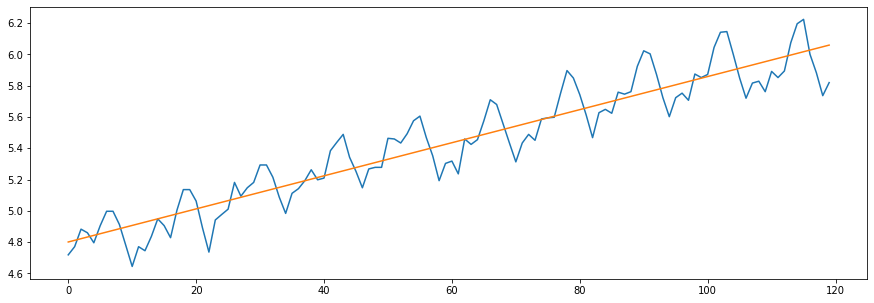

In [7]:
model = LinearRegression()
model.fit(x_train.reshape(-1, 1), train_log)
train_log_tendencia = model.predict(x_train.reshape(-1, 1))

_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_log)
ax.plot(x_train, train_log_tendencia)

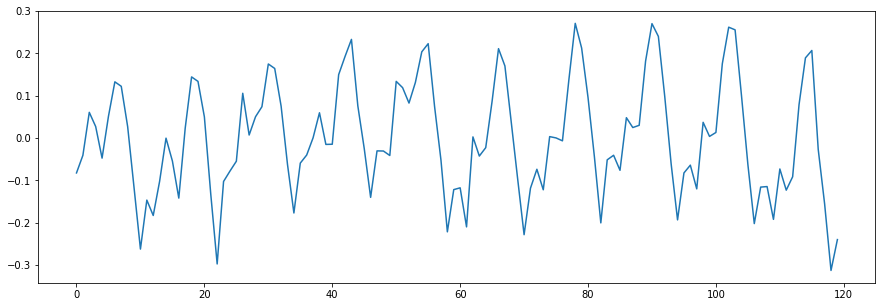

In [8]:
train_log_tendencia = (train_log - model.predict(x_train.reshape(-1, 1))).squeeze()
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train_log_tendencia)

### 1.1.c. Estacionalidad

Definimos la estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad). En este apartado se debe encontrar y eliminar la estacionalidad. 

#### 1.1.c.a. Encontrar el periodo de la estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> en primer lugar debeis encontrar el ciclo, es decir, cada cuánto se repiten los datos. Para ello podemos usar la autocorrelación (numpy te permite obtener los coeficientes de correlación). Graficar los coeficientes para los 22 primeros valores de autocorrelación y determinar su valor máximo, está será nuestra estacionalidad. Dar una interpretación semántica del resultado obtenido.
</div>

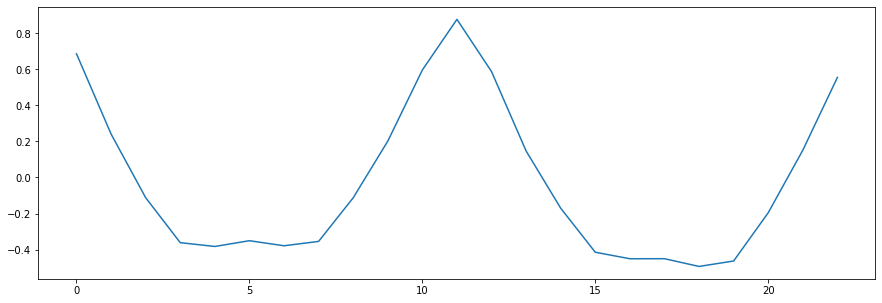

In [9]:
coeficientes_de_correlacion = []
for i in range(1, 24):
    coeficientes_de_correlacion.append(np.corrcoef(train_log_tendencia[i:], train_log_tendencia[:-i])[0,1])
    
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(len(coeficientes_de_correlacion)), coeficientes_de_correlacion)

#### 1.1.c.b. Calcular el patron de estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> ahora que ya conocéis el ciclo, debéis calcular el patrón (el molde de la estacionalidad). Es decir, para cada punto, calcular la mediana de ese punto en cada uno de los ciclos de la serie. 
</div>

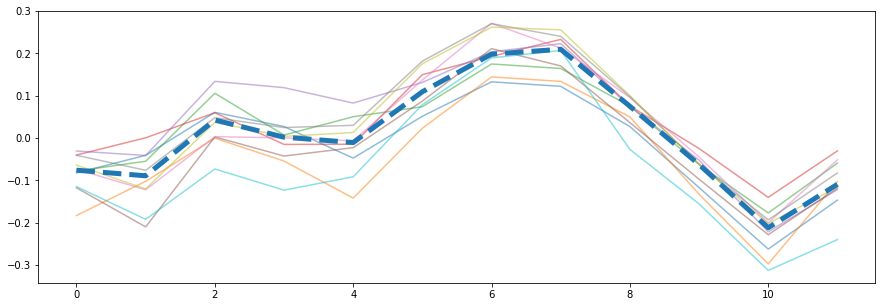

In [10]:
estacionalidad = np.zeros((int(train_log_tendencia.size/12), 12))
_, ax = plt.subplots(1, 1, figsize=(15, 5))
for i, j in enumerate(range(0, train_log_tendencia.size, 12)):
    estacionalidad[i,:] = train_log_tendencia[j:j + 12]
    ax.plot(range(12), train_log_tendencia[j:j + 12], alpha=.5)
estacionalidad_mediana = np.median(estacionalidad, axis=0)
ax.plot(range(12), estacionalidad_mediana, '--', lw=5)

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> una vez obtenido el patrón, replicadlo a lo largo de toda la serie temporal. Cuando lo hayáis calculado debéis restarlo de la serie temporal (sin tendencia ni heterocedasticidad). Graficar los datos con estacionalidad junto con los datos sin estacionalidad.
</div>

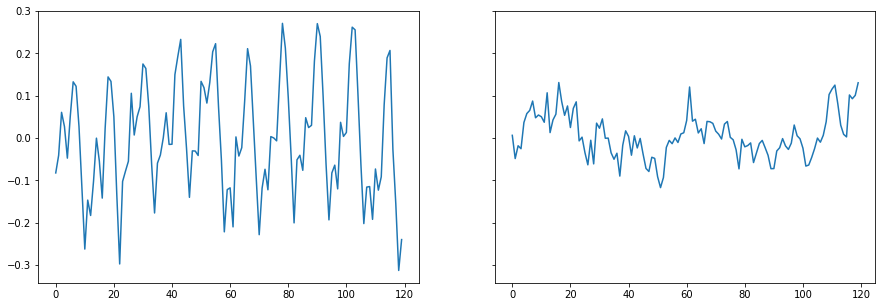

In [11]:
estacionalidad_full = np.tile(estacionalidad_mediana, int(train_log_tendencia.size/12))
noise = estacionalidad_full - train_log_tendencia
_, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 5))
ax[0].plot(x_train, train_log_tendencia)
ax[1].plot(x_train, noise)

### 1.1.d. Ruido

Una vez eliminadas la heterocedasticidad, la tendencia y la estacionalidad, lo que nos queda es el ruido. El ruido sigue una distribución normal. En este apartado debeis encontrar los parámetros de la distribución que sigue el ruido (media y desviación estandard).

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> encontrar la distribución que tiene el ruido (media y desviación estándard). Podéis usar scipy.stats. Graficar un histograma del ruido junto con un histograma de la distribución teórica que tiene el ruido.
</div>

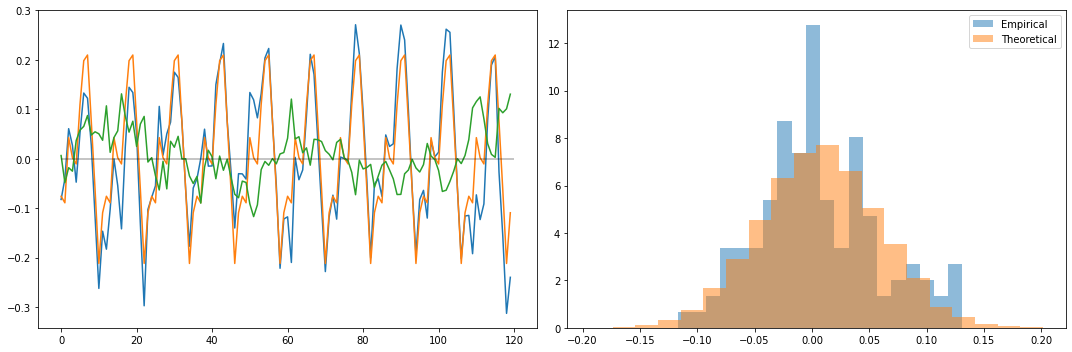

In [12]:
mu, sigma = scipy.stats.norm.fit(noise)

_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_train, train_log_tendencia)
ax[0].plot(x_train, estacionalidad_full)
ax[0].plot(x_train, noise)

ax[0].hlines(0, 0, x_train.size, 'k', alpha=.3)
ax[1].hist(noise, 20, alpha=.5, label='Empirical', density=1)
ax[1].hist(np.random.normal(mu, sigma, size=x_train.size * 100), 20, alpha=.5, label='Theoretical', density=1)
ax[1].legend()

plt.tight_layout()

## 1.2. Predicción

Vamos a predecir los dos proximos años y comparar la predicción con los datos reales. Para ello seguiremos los siguientes pasos:

   - Generar ruido
   - Añadir estacionalidad
   - Añadir tendencia
   - Añadir heterocedasticidad

### 1.2.a. Ruido

Como hemos visto que el ruido se distribuye aleatoriamente siguiendo una distribución normal, vamos a generar ruido siguiendo esta distribución.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> genera dos años de datos de ruido (24 muestras) usando la distribución encontrada en el apartado 1.1.d. Podéis usar el módulo random de numpy. Grafica los resultados.
</div>

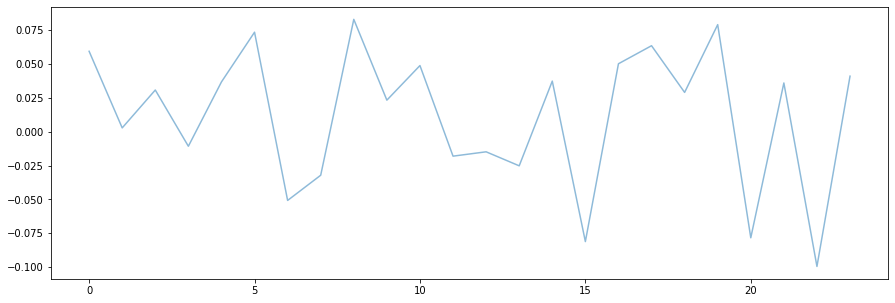

In [13]:
ruido_24_meses = np.random.normal(mu, sigma, size=TEST_SIZE)
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(TEST_SIZE), ruido_24_meses, alpha=0.5)

### 1.2.b. Estacionalidad

Anteriormente hemos calculado la estacionalidad y el ciclo de la serie temporal. Vamos a usar esta estacionalidad ya calculada para añadirla a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido calculados en el apartado anterior los dos años de estacionalidad encontrada en el apartado 1.1.c. Grafica los resultados.
</div>

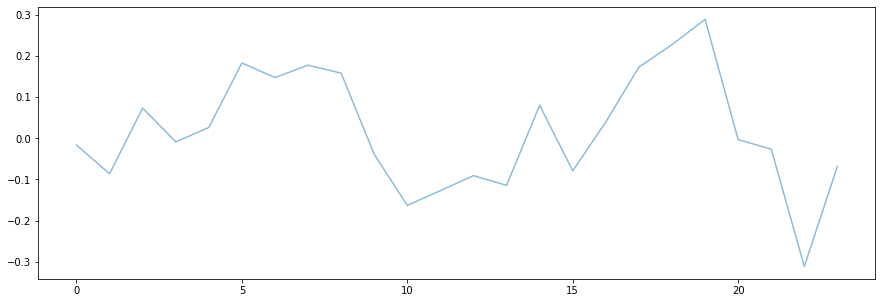

In [15]:
estacionalidad_24_meses = ruido_24_meses + np.tile(estacionalidad_mediana, int(TEST_SIZE / 12))
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(TEST_SIZE), estacionalidad_24_meses, alpha=0.5)

### 1.2.c. Tendencia

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido + estacionalidad calculados en el apartado anterior la tendencia encontrada en el apartado 1.1.b. Grafica los resultados.
</div>

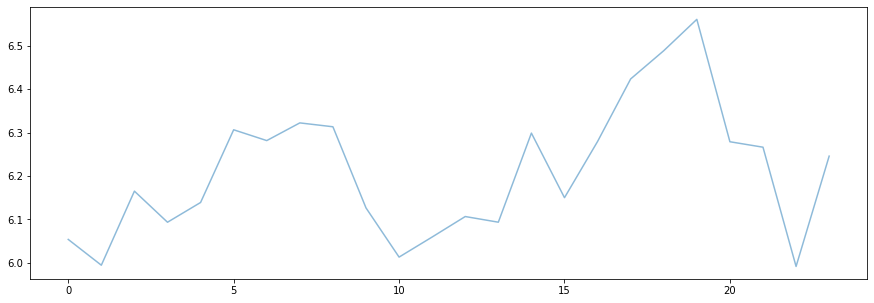

In [16]:
tendencia_estacionalidad_ruido = estacionalidad_24_meses + model.predict(x_test.reshape(-1, 1)).squeeze()
_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(range(TEST_SIZE), tendencia_estacionalidad_ruido, alpha=0.5)

### 1.2.d. Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido + estacionalidad + tendencia calculados en el apartado anterior la heterocedasticidad aplicando la función inversa a la encontrada en el apartado 1.1.a. Grafica el resultado junto con la serie completa y compara la predicción obtenida con los datos reales.
</div>

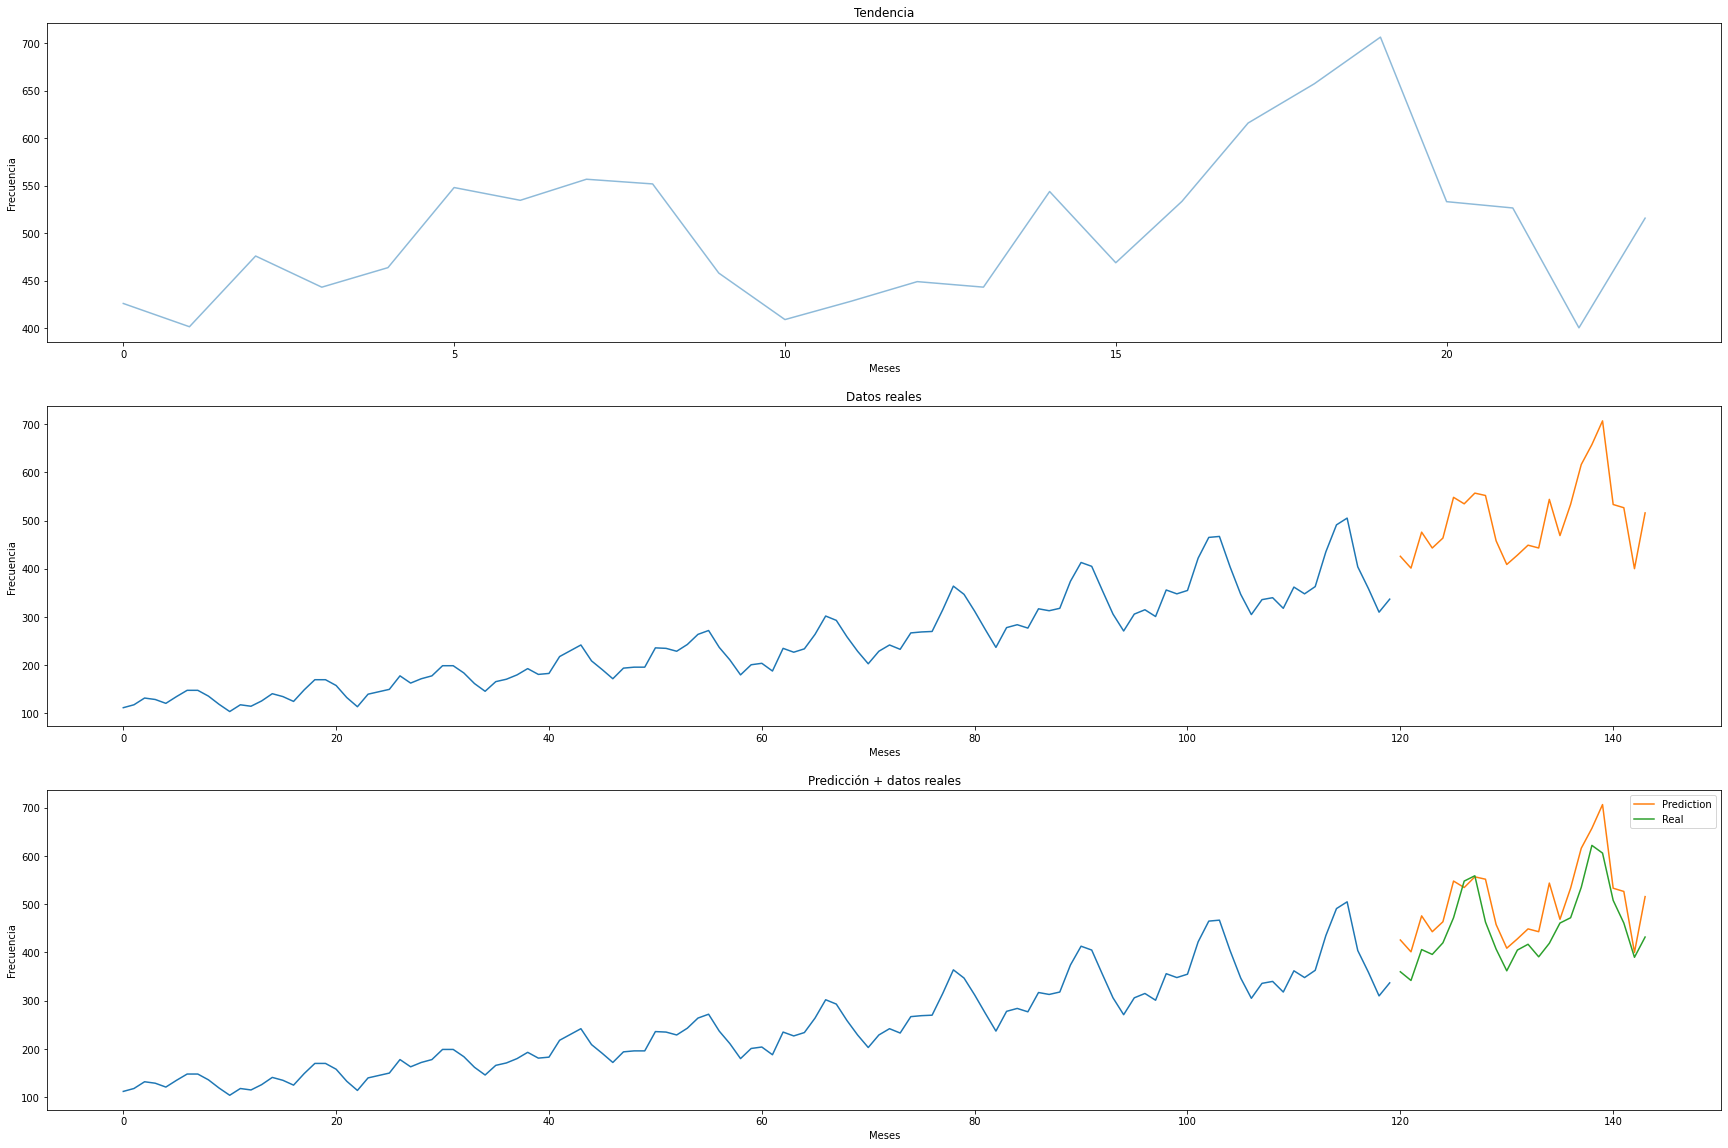

In [18]:
prediccion = np.exp(tendencia_estacionalidad_ruido)

_, ax = plt.subplots(3, 1, figsize=(30, 20))
ax[0].plot(range(TEST_SIZE), prediccion, alpha=0.5)
ax[0].title.set_text('Tendencia')
ax[0].set(xlabel="Meses",ylabel="Frecuencia")

ax[1].plot(x_train, train)
ax[1].plot(x_test, prediccion)
ax[1].title.set_text('Datos reales')
ax[1].set(xlabel="Meses",ylabel="Frecuencia")

ax[2].plot(x_train, train)
ax[2].plot(x_test, prediccion, label='Prediction')
ax[2].plot(x_test, test, label='Real')
ax[2].title.set_text('Predicción + datos reales')
ax[2].set(xlabel="Meses",ylabel="Frecuencia")
ax[2].legend()

<div class="alert alert-block alert-info">
    <strong>[Bonus] Implementación:</strong> como la distribución del ruido generado es aleatoria, en cada ejecución obtendremos predicciones distintas. Una manera de asegurar que la predicción obtenida es fiable es generando intervalos de confianza. 
    <hr>
Para ello vamos a repetir los pasos anteriores pero generando 500 muestras de dos años de longitud cada una (o sea 500 predicciones). Una vez generadas definimos:
    
   - Intervalo de confianza = (min(predicciones), max(predicciones))
   - Predicción final = median(predicciones)
   
Graficar:

   - La serie temporal entera
   - Los dos años de predicción (mediana de las 500 muestras de predicción)
   - El valor real de los dos años que hemos predicho 
   - Los intérvalos de confianza (min y max de las 500 muestras de predicción) 

Para graficar los intérvalos de confianza podéis usar fill_between de matplotlib.
</div>

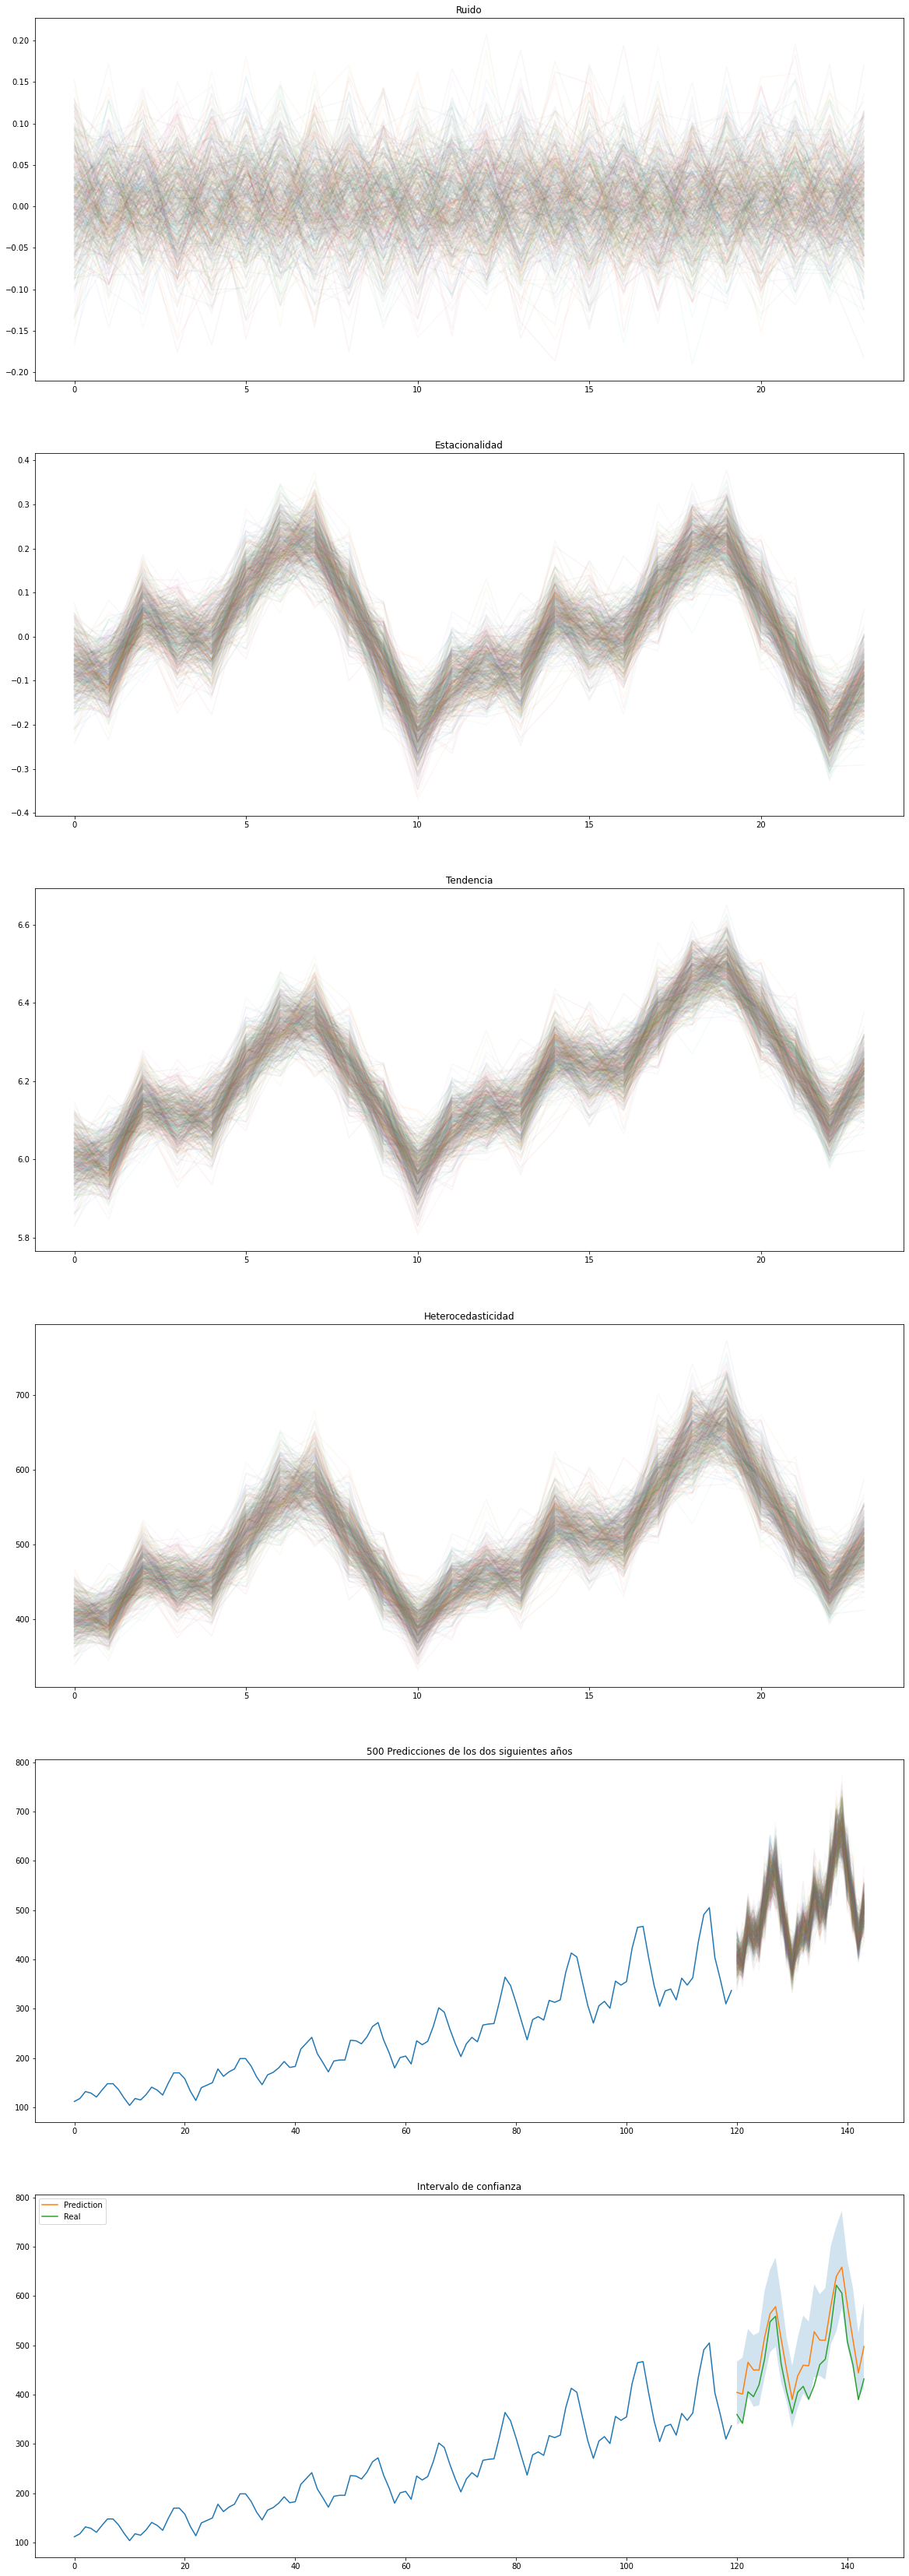

In [20]:
N_SAMPLES = 500
_, ax = plt.subplots(6, 1, figsize=(20, 60))

# Ruido
ruido = np.random.normal(mu, sigma, size=(N_SAMPLES, TEST_SIZE))
ax[0].title.set_text('Ruido')
for i in range(N_SAMPLES):
    ax[0].plot(range(TEST_SIZE), ruido[i,:], alpha=.05)
    
    
# Estacionalidad
estacionalidad_ruido = ruido + np.tile(np.tile(estacionalidad_mediana, int(TEST_SIZE / 12)), N_SAMPLES).reshape(N_SAMPLES, TEST_SIZE)
ax[1].title.set_text('Estacionalidad')
for i in range(N_SAMPLES):
    ax[1].plot(range(TEST_SIZE), estacionalidad_ruido[i,:], alpha=.05)
    
    
# Tendencia
tendencia_estacionalidad_ruido = estacionalidad_ruido + np.tile(model.predict(x_test.reshape(-1, 1)).squeeze(), N_SAMPLES).reshape(N_SAMPLES, TEST_SIZE)
ax[2].title.set_text('Tendencia')
for i in range(N_SAMPLES):
    ax[2].plot(range(TEST_SIZE), tendencia_estacionalidad_ruido[i,:], alpha=.05)
    

# Heterocedasticidad
prediccion = np.exp(tendencia_estacionalidad_ruido)
ax[3].title.set_text('Heterocedasticidad')
for i in range(N_SAMPLES):
    ax[3].plot(range(TEST_SIZE), prediccion[i,:], alpha=.05)


# 500 Predicciones de los dos siguientes años 
ax[4].plot(x_train, train)
ax[4].title.set_text('500 Predicciones de los dos siguientes años')
for i in range(N_SAMPLES):
    ax[4].plot(x_test, prediccion[i,:], alpha=.05)

    
# Intervalo de confianza
pred_mean = np.median(prediccion, axis=0)
upper_bound = np.max(prediccion, axis=0)
lower_bound = np.min(prediccion, axis=0)
ax[5].title.set_text('Intervalo de confianza')
ax[5].plot(x_train, train)
ax[5].plot(x_test, pred_mean, label='Prediction')
ax[5].plot(x_test, test, label='Real')
ax[5].fill_between(x_test, upper_bound, lower_bound, alpha=.2)
ax[5].legend(loc='upper left')

# 2. Combinación de clasificadores (5 puntos)

En este ejercicio utilizaremos un subconjunto de 5.000 imágenes provenientes del corpus EMNIST, constituido por carácteres y dígitos escritos a mano
. Dicho subconjunto está formado por 1.000 imágenes para cada una de las 5 clases diferentes ("A", "B", "C", "D" y "E").

La primera parte de este ejercicio abordará la combinación de clasificadores en paralelo mediante las tecnicas de **_Bagging_** y **_Boosting_**.

Mientras que la segunda parte pretende mejorar los resultados aplicando tecnicas de combinación secuencial de clasificadores: **_Stacking_** y **_Cascading_**.

Para empezar, vamos a visualizar el dataset. Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones. El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [21]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["A", "B", "C", "D", "E"]

print("Dimensiones del vector de imágenes: {}".format(images.shape))
print("Dimensiones del vector de etiquetas: {}".format(labels.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

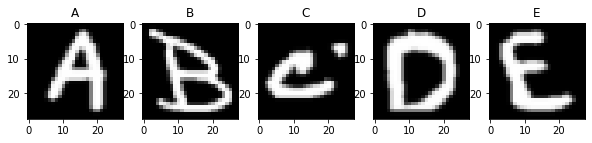

In [23]:
_, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

Para poder probar varios modelos, primero vamos a dividir el dataset en train y test.

La división con la función *train_test_split* es aleatoria , pero para que todos obtengáis los mismos resultados y poder comentar dudas por el foro, fijaremos la seed para obtener los mismos datasets de train y test. El *split* tendrá en cuenta que los dos conjuntos tengan el mismo número de ejemplos para cada una de las clases gracias al parámetro *stratify=labels*.

Como en la segunda parte de este ejercicio trataremos *stacking* y *cascading*, y ambos se aplican sobre el conjunto de test, haremos un *split* del 50% para tener un poco más de base al aplicar estas dos técnicas.

In [25]:
myseed = 13

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5,
                                                    random_state=myseed, 
                                                    stratify=labels)

## 2.1. Combinación paralela de clasificadores

### 2.1.1. Árbol de decisión

Para poder comparar el aumento de *performance* obtenido a medida que aplicamos técnicas nuevas, utilizaremos como *baseline* un simple árbol de decisión.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Evalúa la precisión de un árbol de decisión con profundidad máxima de 5 niveles (aplicaremos la misma restricción en las siguientes secciones) aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
       
<u>Sugerencia</u>: usar el módulo *cross_val_score* de *sklearn*. Para aprender más sobre *cross validation* y sobre cómo usar estos módulos, os recomendamos los siguientes enlaces: 
- http://scikit-learn.org/stable/modules/cross_validation.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

In [46]:
decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree_score = cross_val_score(decision_tree, X_train, y_train, cv=3)
print(f"Score: {np.mean(decision_tree_score)}")

decision_tree.fit(X_train, y_train)
y_predicted = decision_tree.predict(X_test)

decision_tree_precision = precision_score(y_test, y_predicted, average='micro')
print(f"Precisión: {np.mean(decision_tree_precision)}")

Score: 0.7936056916771504
Precisión: 0.794


### 2.1.2. *Bagging*

#### 2.1.2.a. Random Forest

La idea básica del bagging es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo Random Forest, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (el Random Forest) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
        
Evalúa la precisión de un <i>random forest</i> combinando 20 árboles de decisión con profundidad máxima de 5 niveles aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

In [47]:
random_forest_model = RandomForestClassifier(max_depth=5, n_estimators=20)
random_forest_model_score = cross_val_score(random_forest_model, X_train, y_train, cv=3)
print(f"Score: {np.mean(random_forest_model_score)}")

random_forest_model.fit(X_train, y_train)
y_predicted = random_forest_model.predict(X_test)

random_forest_model_precision = precision_score(y_test, y_predicted, average='micro')
print(f"Precisión: {np.mean(random_forest_model_precision)}")

Score: 0.8808041202092348
Precisión: 0.8864


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

Tanto la precisión como el _score_ de Random Forest son significativamente mejores que los obtenidos con un único árbol de decisión. Esto tiene sentido, puesto que media los resultados obtenidos mediante muestras aleatorias, permitiendo así reducir sustancialmente el sesgo, ofreciendo más estabilidad y seguridad en los resultados.

#### 2.1.2.b. Out-of-bag

Una ventaja del *bagging* usado en el *Random Forest* es que cada uno de los árboles de decisión ha sido entrenado con una combinación diferente de los datos (muestreo con reemplazo), es decir, cada uno de los árboles no ha visto una determinada parte de los datos originales. Esto define una especie de conjunto de test para cada uno de los árboles, llamado *out-of-bag*, que puede ser usado para estimar el error del modelo sin necesidad de usar el conjunto de test real que creamos previamente, ni de usar estrategias de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
      
Entrena sobre el conjunto de train un modelo de <i>random forest</i> combinando 20 árboles de decisión con profundidad máxima de 5 niveles y muestra la precisión de este modelo en el *out-of-bag*.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender más sobre *out-of-bag* y sobre como usar este módulo (incluyendo el atributo *oob&#95;score_*), os recomendamos los siguientes enlaces:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

</div>

In [54]:
# Definición del modelo
random_forest_oob_model = RandomForestClassifier(max_depth=5, n_estimators=20, oob_score=True)

# Entrenamiento
random_forest_oob_model.fit(X_train, y_train)

print(f"OOB Score train: {random_forest_oob_model.score(X_train, y_train)}")
print(f"OOB Score test: {random_forest_oob_model.score(X_test, y_test)}")

OOB Score train: 0.9188
OOB Score test: 0.8824


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿la precisión obtenida en el <i>out-of-bag</i> y con los métodos de validación anteriores son comparables? ¿Era de esperar? 
</div>

El resultado del _OOB score_ en train es mayor que los hasta ahora obtenidos, no obstante, es muy factible que se de a raíz del aumento en el sesgo de entrenar y clasificar con los mismos datos. En cuanto al _OOB score_ con el conjunto de test, es muy similar al resto de los obtenidos previamente.

#### 2.1.2.c. Número de clasificadores agregados

En los ejercicios anteriores hemos combinado 20 clasificadores simples en nuestro clasificador combinado. ¿Será que la precisión del clasificador combinado aumenta indefinidamente su desempeño si añadimos más clasificadores?

Para responder a esta pregunta vamos a representar una curva de validación. La curva de validación es una representación gráfica del desempeño de un modelo variando uno de sus parámetros. Esto nos permite entender cuál es el impacto de un determinado parámetro en el desempeño de un modelo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>    
Entrena varios modelos de <it>Random Forest</it> con un número de árboles cada vez mayor. Para cada modelo, calcula su precisón en el conjunto de test o usando *cross-validation* en el conjunto de entrenamiento. Opcional: representa gráficamente la evolución de la precisión con el número de árboles para ayudarte en el análisis de los resultados.
<br><br>
    
<u>Sugerencia</u>: usar el módulo *validation_curve* de sklearn. Para aprender a usar este módulo os recomendamos los siguientes enlaces:<br>
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
- http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

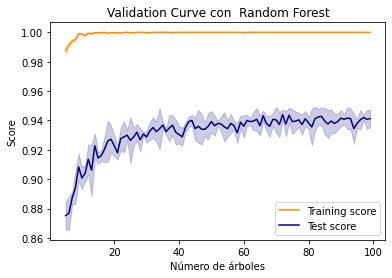

In [90]:
# Se definen de 10 a 100 árboles
param_range = np.arange(5,100)

# Entrenamiento de todos los árboles y obtención del score
train_scores, test_scores = validation_curve(RandomForestClassifier(),
                                    X_train, y_train,
                                    param_name="n_estimators",
                                    param_range=param_range,
                                    cv=3, 
                                    scoring="accuracy", 
                                    n_jobs=-1)

# Obtención de las medias y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Referencias de la gráfica
plt.title("Validation Curve con  Random Forest")
plt.xlabel("Número de árboles")
plt.ylabel("Score")

plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange"
)

plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange"
)

plt.plot(
    param_range, test_scores_mean, label="Test score", color="navy"
)

plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy"
)

plt.legend(loc="best")
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿incrementa indefinidamente la precisión con el número de árboles combinados o se satura en una precisión límite? ¿Por qué?
</div>

Entrenando Random Forest con un número de árboles entre 5 y 100, se puede ver cómo se estabiliza el valor a partir de cierto número de árboles desde donde el score en test se mantiene en 0.94 aproximadamente.

### 2.1.3. *Boosting*

En el sistema de Boosting se combinan varios clasificadores débiles sequencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificados en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>

Evalúa la precisión de un <i>gradient boosting</i> con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i> aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *GradientBoostingClassifier* de sklearn. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

In [92]:
gb = GradientBoostingClassifier(n_estimators=20, 
                                learning_rate=1.0, 
                                max_depth=5, 
                                random_state=0).fit(X_train, y_train)
gb.score(X_test, y_test)

0.9284

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

Sí ha mejorado respecto a un simple árbol, pasando de un 0.8 a un 0.93. Era de esperar que mejorara puesto que este modelo busca corregir los casos en los que ha fallado, por lo que este tipo de optimización es mucho mejor que un tratamiento equitativo de los casos.

## 2.2. Combinación secuencial de clasificadores base diferentes

Para poder hacer combinación secuencial de modelos, necesitamos tener varios modelos diferentes entrenados. En nuestro caso, ya tenemos un árbol de decisión, el *random forest* y el *gradient boosting*. Vamos a entrenar un par de modelos más.

### 2.2.1 Clasificadores adicionales

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Entrena un <i>k-neighbors</i> con 2 vecinos sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 

Entrena un SVM (Suport vector machines) con gamma = 0.07 sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 
</div>  

In [95]:
# Definición del modelo
knn = KNeighborsClassifier(n_neighbors=2)

#Entrenamiento
knn.fit(X_train, y_train)

# Predicción
knn_predicted = knn.predict(X_test)

knn_precision = precision_score(y_test, knn_predicted, average='micro')
print(f"Precisión: {np.mean(knn_precision)}")

Precisión: 0.9212


In [101]:
# Definición del modelo
svm = SVC(gamma=0.07)

# Entrenamiento
svm.fit(X_train, y_train)

# Predicción
svm_predicted = svm.predict(X_test)

svm_precision = precision_score(y_test, svm_predicted, average='micro')
print(f"Precisión: {np.mean(svm_precision)}")

Precisión: 0.2


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> comenta los resultados.
</div>

La predicción del k-NN es bastante buena, alcanzando valores parecidos a los demás clasificadores más complejos, sin embargo el modelo SVM es pésimo, no solamente porque el nivel de precisión es de 0.20, sino porque aún invirtiendo sus resultados y obteniendo una precisión del 0.80, sigue siendo peor que los demás.

### 2.2.2 *Stacking*

Un clasificador de *stacking* usa como atributos las predicciones hechas por otros clasificadores en lugar de los datos originales de entrada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>stacking</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones hechas en el conjunto de test por los algoritmos: 
    
- árbol de decisión
- random forest
- gradient boosting
- knn
- svm 
 
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test (en este caso no tenemos conjunto de train, con lo cual se hace directamente cross-validation sobre test).

<u>Sugerencia</u>: usar la función column_stack de numpy para juntar todas las predicciones. Dado que las variables que usaremos ahora como predictors son categóricas, es preferible transformarlas en *dummies* (*one-hot-encoding*). Para apender a usar estas funciones os recomendamos los siguientes enlaces:
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>stacking</i>? Comenta los resultados.
</div>

### 2.2.3. *Cascading*

El caso de *cascading* es parecido al de *stacking* pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>cascading</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones obtenidas con los modelos anteriores en el conjunto de test (igual que con el <i>stacking</i>), y también las variables originales. 
    
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test.

<u>Sugerencia</u>: Usa el mismo conjunto de datos que en el ejercicio anterior pero añade `X_test`.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>cascading</i>? Comenta los resultados.
</div>